# RL moments

To demonstrate how to calculate RL moments, I'll use a new set of LOSVD models called convolution models (Jethwa et al. in prep). 

Convolution models take five parameters:
- $V$ = mean,
- $\sigma$ = standard deviation,
- $\sigma_K \geq 0$ controls overall magnitude of non-gaussianity,
- $-0.6 < \delta < 0.6$ controls skewness
- $-1< \kappa < 1$ controls kurtosis

/Users/prash/Astro/Software/momoments/convmods/convmods.py:143: RuntimeWarning: invalid value encountered in divide
  Fk = 0.5*(np.exp(iau_min)-1.)/iau_min
/Users/prash/Astro/Software/momoments/convmods/convmods.py:144: RuntimeWarning: invalid value encountered in divide
  Fk += 0.5*(np.exp(iau_pls)-1.)/iau_pls


(-80.0, 80.0)

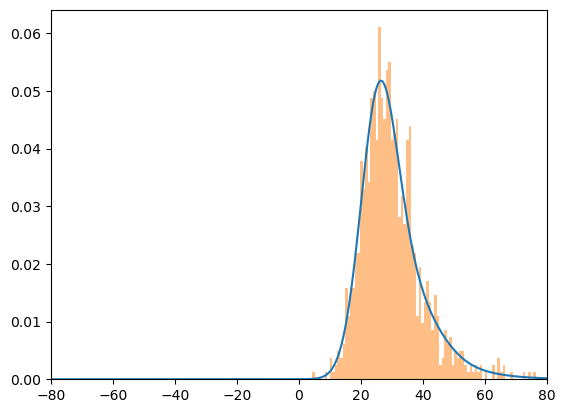

In [1]:
import convmods.convmods as cnv
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(423543)

V, sigma = 30, 10
sigmaK, delta, kappa = 1.5, 0.5, 0.8

# initialise a convolution model LOSVD
kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa)
losvd = cnv.LOSVD(V=V, sigma=sigma, kernel=kernel)

# plot pdf
v, pdf = losvd.evaluate_via_fft(vmax=300., nv=1001)
plt.plot(v, pdf)

# plot histogram of samples drawn from LOSVD
v_smp = losvd.rvs(1000)
h, v_edg, _ = plt.hist(v_smp, density=True, bins=100, alpha=0.5)

plt.gca().set_xlim(-80, 80)

We can calculate the RL moments in two ways. First, using the estimator for discrete samples,

In [2]:
import momoments.rl_moments as rlm

rl_moms = rlm.sample_rl_moments(v_smp)
rl_moms = np.squeeze(rl_moms)
print(f'rl skewness = {rl_moms[0]}')
print(f'rl kurtosis = {rl_moms[1]}')

rl skewness = 0.2184437798128388
rl kurtosis = 0.1008459968720785


And, secondly, using the integral over the LOSVD,

In [3]:
v, pdf = losvd.evaluate_via_fft(vmax=200., nv=1000001)
dv = v[1] - v[0]
v_edg = np.concatenate(([v[0]-dv/2], v+dv/2.))

rl_moments_from_integral = rlm.integral_rl_moments(pdf, v_edg)
rl_moments_from_integral = np.squeeze(rl_moments_from_integral)
print(f'rl skewness = {rl_moments_from_integral[0]}')
print(f'rl kurtosis = {rl_moments_from_integral[1]}')

rl skewness = 0.2380987665376405
rl kurtosis = 0.10198061336111718


The two estimators should approach one another as (i) the number of samples increases in the sample estimator, and (ii) the discretisation od the integration is fine enough (large `nv`) and over a large enough extent (large `vmax`).

The integral form of the RL moment calculation is vectorised, so we can quickly calculate RL moments of a large number of LOSVDs. For example, let's take a set of convolution models with a 3D grid of paramaters $(\sigma_K, \delta, \kappa)$:

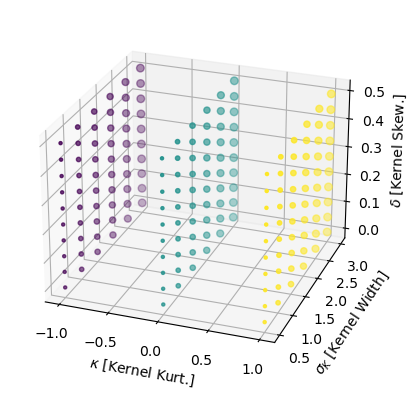

In [4]:
sigmaK_arr = np.linspace(0.5, 3., 6)
delta_arr = np.linspace(0, 0.5, 10)
kappa_arr = [-1, 0, 1]

V, sigma = 0, 1
vmax, nv = 10, 10001

ss, dd, kk = np.meshgrid(sigmaK_arr, delta_arr, kappa_arr, indexing='ij')
sigmaK_list = np.ravel(ss)
delta_list = np.ravel(dd)
kappa_list = np.ravel(kk)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(kappa_list, sigmaK_list, delta_list, c=kappa_list, s=sigmaK_list*10)
ax.set_xlabel('$\kappa$ [Kernel Kurt.]')
ax.set_ylabel('$\sigma_K$ [Kernel Width]')
ax.set_zlabel('$\delta$ [Kernel Skew.]')
ax.azim -= 10
ax.elev -= 5

Let's evaluate the models,

In [5]:
evaluated_losvds = []
for sigmaK, delta, kappa in zip(sigmaK_list, delta_list, kappa_list):
    kernel = cnv.Kernel(sigmaK=sigmaK, delta=delta, kappa=kappa)
    losvd = cnv.LOSVD(V=0, sigma=1, kernel=kernel)
    v, pdf = losvd.evaluate_via_fft(vmax=100, nv=50001)
    evaluated_losvds += [list(pdf)]
evaluated_losvds = np.array(evaluated_losvds)

and calculate the RL moments of all the models as follows,

In [6]:
dv = v[1] - v[0]
v_edg = np.concatenate(([v[0]-dv/2], v+dv/2.))

rlmoms = rlm.integral_rl_moments(evaluated_losvds, v_edg)
rlmoms.shape

(2, 180)

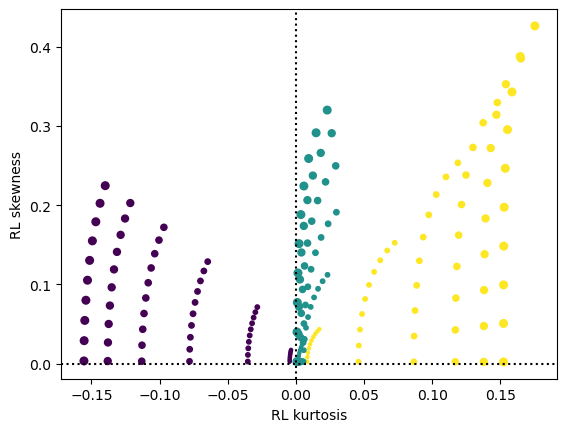

In [7]:
plt.scatter(rlmoms[1], rlmoms[0], c=kappa_list, s=sigmaK_list*10)
plt.gca().set_xlabel('RL kurtosis')
plt.gca().set_ylabel('RL skewness')
plt.gca().axhline(0, ls=':', color='k')
plt.gca().axvline(0, ls=':', color='k')